# Risk estimation for event sequence

Author: Xinyu Zhao, Arizona State University 

Email: xzhao119@asu.edu

This notebook shows a case study for event sequence risk estimation. 

# Code Requirements

Following is the package requirements for the notebook
- Pytorch 1.4.0
- catboost 0.23
- xgboost 1.0.2
- sklearn 0.21.3

In [8]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from os import listdir
from os.path import isfile, join
from collections import Counter
from util import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load data

In [15]:
occurrence_code_corpus = np.load("data/occurrence_code_corpus.npy")
subject_code_corpus = np.load("data/subject_code_corpus.npy")
phase_code_corpus = np.load("data/phase_code_corpus.npy")
subj_to_occurrence_dict = pd.read_pickle("data/subj_to_occurrence_dict.pkl")
occurrence_to_subj_dict = pd.read_pickle("data/occurrence_to_subj_dict.pkl")
phase_to_occurrence_dict = pd.read_pickle("data/phase_to_occurrence_dict.pkl")
occurrence_to_phase_dict = pd.read_pickle("data/occurrence_to_phase_dict.pkl")

In [3]:
ev_id = '20001208X07734'
mypath = 'data/ntsb'
#Main tables 
events = pd.read_csv(mypath+'/events.csv')
aircraft = pd.read_csv(mypath+'/aircraft.csv')
Events_Sequence = pd.read_csv(mypath+'/Events_Sequence.csv')
Occurrences = pd.read_csv(mypath+'/Occurrences.csv')
seq_of_events = pd.read_csv(mypath+'/seq_of_events.csv')
DataDict = pd.read_csv('data/eADMSPUB_DataDictionary.csv')

events_select = events[['ev_id','ev_type','mid_air','on_ground_collision', 'ev_highest_injury', 'inj_f_grnd',
       'inj_m_grnd', 'inj_s_grnd', 'inj_tot_f', 'inj_tot_m', 'inj_tot_n',
       'inj_tot_s', 'inj_tot_t']]
aircraft_select = aircraft[['ev_id', 'damage','phase_flt_spec']]
Occurrences_select = Occurrences[['ev_id', 'Aircraft_Key', 'Occurrence_No', 'Occurrence_Code',
       'Phase_of_Flight']]
seq_of_events_select = seq_of_events[['ev_id', 'Aircraft_Key', 'Occurrence_No', 'seq_event_no',
       'group_code', 'Subj_Code', 'Cause_Factor', 'Modifier_Code']]
Occurrences_merge = pd.merge(Occurrences_select, seq_of_events_select, on=['ev_id', 'Aircraft_Key', 'Occurrence_No'])

In [4]:
select_event = Occurrences_merge[Occurrences_merge['ev_id']==ev_id]
occurrence_list = select_event.loc[:,'Occurrence_Code'].astype(str)
phase_list = select_event.loc[:,'Phase_of_Flight'].astype(str)
subject_list = select_event.loc[:,'Subj_Code'].astype(str)
select_event.loc[:,'Phase_of_Flight'] = [list(phase_code_corpus).index(x) for x in phase_list]
select_event.loc[:,'Occurrence_Code'] = [list(occurrence_code_corpus).index(x) for x in occurrence_list]
select_event.loc[:,'Subj_Code'] = [list(subject_code_corpus).index(x) for x in subject_list]
select_event = select_event.groupby(['ev_id','Aircraft_Key'])['Occurrence_No','Occurrence_Code','Phase_of_Flight','Subj_Code'].agg(lambda x: x.tolist()).reset_index()
select_event.at[0,'Occurrence_Code'] = [0] + select_event.loc[0,'Occurrence_Code'] + [1]
select_event.at[0,'Phase_of_Flight'] = [0] + select_event.loc[0,'Phase_of_Flight'] + [1]
select_event.at[0,'Subj_Code'] = [0] + select_event.loc[0,'Subj_Code'] + [1]

/home/xinyu/miniconda3/envs/pytorch/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [9]:
show_event(Occurrences_merge, ev_id, DataDict).drop(['seq_event_no', 'group_code'], axis=1)[['Subj_Code','Occurrence_Code']]

,Subj_Code,Occurrence_Code
30120,"Electrical system, alternator",Airframe/component/system failure/malfunction
30121,Instrument light(s),Airframe/component/system failure/malfunction
30122,Vacuum system,Airframe/component/system failure/malfunction
30123,Aircraft control,Loss of control - in flight
30124,Spatial disorientation,Loss of control - in flight
30125,Inadequate recurrent training,Loss of control - in flight
30126,Airframe,Airframe/component/system failure/malfunction
30127,Terrain condition,In flight collision with terrain/water


# Load Model 

In [12]:
from util import *
subject_size = len(subject_code_corpus)
phase_size = len(phase_code_corpus)
occurrence_size = len(occurrence_code_corpus)
isRNN = True
batch_size = 1
device = torch.device('cuda:2')
if isRNN:
    embedding_dim = 30  # Embedding of each word
    hidden_dim = 30      #Final hidden dimension that is used for prediction
    num_layer = 2        # Number of layers 
    latent_dim = 30     # Latend dimension 

    model =  RNNModel(phase_size, occurrence_size, subject_size, embedding_dim, latent_dim, num_layer, batch_size, hidden_dim, device).to(device)
    hierarchical_softmax = HierarchicalSoftmax(hidden_dim, phase_to_occurrence_dict, occurrence_to_subj_dict,subj_to_occurrence_dict,device).to(device)
    hierarchical_softmax.load_state_dict(torch.load('model/hierarchical_softmax_rnn_20200801_1227_rnn__19.sav'))
    model.load_state_dict(torch.load('model/model_rnn_20200801_1227_rnn__19.sav'))
else:
    embedding_dim = 100  # Embedding of each word
    hidden_dim = 50      #Final hidden dimension that is used for prediction

    num_layer = 2        # Number of layers 
    latent_dim = 100     # Latend dimension 
    model = SequentialPrediction(phase_size,occurrence_size,subject_size, embedding_dim, batch_size,hidden_dim, device)
    hierarchical_softmax = HierarchicalSoftmax(hidden_dim, phase_to_occurrence_dict, occurrence_to_subj_dict,subj_to_occurrence_dict,device).to(device)
    hierarchical_softmax.load_state_dict(torch.load('hierarchical_softmax_sequential_20200520_1920_nornn__5.sav'))
    model.load_state_dict(torch.load('model_sequential_20200520_1920_nornn__5.sav'))


import pickle


mypath = "/home/xinyu/Project/data/aviation_ntsb/raw_data"
dataDict = pd.read_csv(mypath+'/eADMSPUB_DataDictionary.csv')
feature_list = subject_code_corpus.tolist() + occurrence_code_corpus.tolist()+ phase_code_corpus.tolist()
feature_list_meaning = []
for x in feature_list:
    if x == '000':
        feature_list_meaning.append('start')
    elif x == '999':
        feature_list_meaning.append('end')
    elif len(dataDict[dataDict['code_iaids']==x]['meaning'])==0:
        feature_list_meaning.append('unknown')
    else:
        meaning = list(dataDict[dataDict['code_iaids']==x]['meaning'])[0]
        feature_list_meaning.append(meaning)
        
risk_model = pickle.load(open('model/risk_model2.sav', 'rb'))

In [13]:
select_event

,ev_id,Aircraft_Key,Occurrence_No,Occurrence_Code,Phase_of_Flight,Subj_Code
0,20001208X07734,1,"[1, 1, 1, 2, 2, 2, 3, 4]","[0, 3, 3, 3, 55, 55, 55, 3, 47, 1]","[0, 13, 13, 13, 13, 13, 13, 19, 19, 1]","[0, 700, 240, 853, 1421, 204, 308, 680, 620, 1]"


# Event prediction and risk estimation

In [19]:
# predict sequences 
def create_risk_estimator(pred_phase, pred_occurrence, pred_subject):
    subject_buffer = np.zeros(len(subject_code_corpus))
    phase_buffer = np.zeros(len(phase_code_corpus))
    occurrence_buffer = np.zeros(len(occurrence_code_corpus))
    for j in pred_subject:
        subject_buffer[int(j)] = 1
    for j in pred_occurrence:
        occurrence_buffer[int(j)] = 1
    for j in pred_phase:
        phase_buffer[int(j)] = 1
    a = np.concatenate((subject_buffer,occurrence_buffer, phase_buffer),axis=0)
    return a

risk = []
data_total = []
intervention = 4
event_subject_list = []
event_phase_list = []
event_occurrence_list = []
X_subject_buffer = []
X_occurrence_buffer = []
X_phase_buffer = []

phase_proba_buffer =[]
occurrence_proba_buffer = []
subject_proba_buffer = []
event_length = len(select_event['Occurrence_Code'][0])
for i in range(1,len(select_event['Occurrence_Code'][0])-1):
    data_total_buffer = []
    X_subject_input = torch.LongTensor(select_event['Subj_Code'][0][:i+1]).to(device)
    X_occurrence_input = torch.LongTensor(select_event['Occurrence_Code'][0][:i+1]).to(device)
    X_phase_input = torch.LongTensor(select_event['Phase_of_Flight'][0][:i+1]).to(device)
    
    event_subject_list.append(list(DataDict[DataDict['code_iaids']==subject_code_corpus[X_subject_input[-1]]]['meaning'])[0])
    event_phase_list.append(list(DataDict[DataDict['code_iaids']==phase_code_corpus[X_phase_input[-1]]]['meaning'])[0])
    event_occurrence_list.append(list(DataDict[DataDict['code_iaids']==occurrence_code_corpus[X_occurrence_input[-1]]]['meaning'])[0])
    
    if isRNN:  
        hidden = model.init_hidden()
        X, hidden = model(X_phase_input, X_occurrence_input, X_subject_input, len(X_subject_input), hidden)
                       
    else:
        X = model(X_phase_input, X_occurrence_input, X_subject_input, len(X_subject_input))
                  
    X_subject_output = select_event['Subj_Code'][0][1:i+2]
    X_occurrence_output = select_event['Occurrence_Code'][0][:i+2]
    X_phase_output = select_event['Phase_of_Flight'][0][1:i+2]
                  
    phase_proba,  occurance_proba, subject_proba = hierarchical_softmax.predict(X, len(X_subject_input), X_subject_output, X_occurrence_output, X_phase_output)
    
    phase_proba_buffer.append(phase_proba[-1].cpu().detach().numpy().tolist())
    occurrence_proba_buffer.append(occurance_proba[-1].cpu().detach().numpy().tolist())
    subject_proba_buffer.append(subject_proba[-1].cpu().detach().numpy().tolist())
    
    pred_phase = np.zeros(phase_proba.shape[0] + 1)
    pred_occurrence = np.zeros(phase_proba.shape[0] + 1)
    pred_subject = np.zeros(phase_proba.shape[0] + 1)
    nsample = 100
    risk_current = []
    for j in range(nsample):
        for jj in range(phase_proba.shape[0] + 1):
            
            if jj == phase_proba.shape[0]:
                pred_phase[jj] = np.random.choice(phase_proba.shape[1], 1, phase_proba[jj-1].cpu().detach().numpy().tolist())
                pred_occurrence[jj] = np.random.choice(phase_proba.shape[1], 1, phase_proba[jj-1].cpu().detach().numpy().tolist())
                pred_subject[jj] = np.random.choice(phase_proba.shape[1], 1, phase_proba[jj-1].cpu().detach().numpy().tolist())
            else:
                pred_phase[jj] = X_phase_input[jj]
                pred_occurrence[jj] = X_occurrence_input[jj]
                pred_subject[jj] = X_subject_input[jj]

        risk_estimators = create_risk_estimator(pred_phase, pred_occurrence, pred_subject)
        data_total_buffer.append(risk_estimators)
        risk_pred = risk_model.predict(risk_estimators.reshape(1, -1))[0,0]
        
        risk_current.append(risk_pred)
    risk.append(risk_current)
    data_total.append(data_total_buffer)

# Result analysis

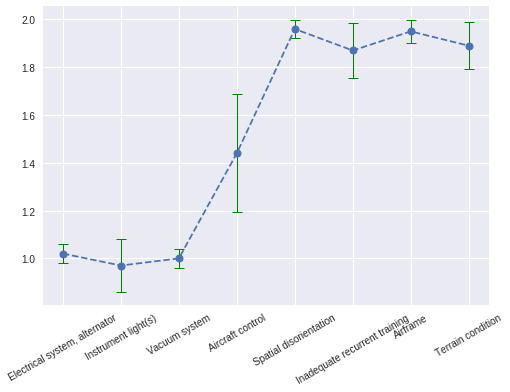

In [20]:
# x = list(show_event(Occurrences_merge, ev_id)['Subj_Code'])[:len(risk)]
name_list = []
# for i in range(len(event_subject_list)):
#     name_list.append(event_phase_list[i]+'\n'+event_occurrence_list[i]+'\n'+event_subject_list[i])
for i in range(len(event_subject_list)):
    name_list.append(event_subject_list[i])
x = name_list
y = np.mean(risk,1)
e = np.var(risk,1)
plt.style.use('seaborn')
plt.rcParams.update({'lines.markeredgewidth': 1})
# plt.errorbar(x, y, e, fmt='--o', ecolor='g')
(_, caps, _) = plt.errorbar(
    x, y, e, fmt='--o', ecolor='g', capsize=5, elinewidth=1)
plt.xticks(rotation=30)

for cap in caps:
    cap.set_markeredgewidth(1)